# Example notebook for training a U-net deep learning network to predict tree cover

This notebook presents a toy example for training a deep learning architecture for semantic segmentation of satellite images using `eo-learn` and `keras`. The example showcases tree cover prediction over an area in Framce. The ground-truth data is retrieved from the [EU tree cover density (2015)](https://land.copernicus.eu/pan-european/high-resolution-layers/forests/view) through [Geopedia](http://www.geopedia.world/#T235_L2081_x449046.043261205_y6052157.300792162_s15_b17).

The workflow is as foolows:
 * input the area-of-interest (AOI)
 * split the AOI into small manageable eopatches
 * for each eopatch:
     * download RGB bands form Sentinel-2 L2A products using Sentinel-Hub for the 2017 year 
     * retrieve corresponding ground-truth from Geopedia using a WMS request
     * compute the median values for the RGB bands over the time-interval
     * save to disk
     * select a 256x256 patch with corresponding ground-truth to be used for training/validating the model
 * train and validate a U-net
 
This example can easily be expanded to:
 * larger AOIs;
 * include more/different bands/indices, such as NDVI
 * include Sentinel-1 images (after harmonisation with Sentinel-2)
 
The notebook requires `Keras` with `tensorflow` back-end.

In [1]:
import os
from os import path as op
import itertools

from eolearn.io import *
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, SaveToDisk, OverwritePermission
from sentinelhub import BBox, CRS, BBoxSplitter, MimeType, ServiceType

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import geopandas

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
K.clear_session()

Using TensorFlow backend.


## 1. Set up workflow

In [2]:
# https://www.sentinel-hub.com/faq/where-get-instance-id
INSTANCE_ID = os.environ.get('INSTANCE_ID')

In [3]:
# global image request parameters
time_interval = ('2017-01-01', '2017-12-31')
img_width = 256
img_height = 256
maxcc = 0.2

In [4]:
# get the AOI and split into bboxes
crs = CRS.UTM_31N
aoi = geopandas.read_file('../../example_data/eastern_france.geojson')
aoi = aoi.to_crs(crs={'init':CRS.ogc_string(crs)})
aoi_shape = aoi.geometry.values.tolist()[-1]

bbox_splitter = BBoxSplitter([aoi_shape], crs, (19, 10))

In [5]:
# set raster_value conversions for our Geopedia task
# see more about how to do this here:

raster_value = {
    '0%': (0, [0, 0, 0, 0]),
    '10%': (1, [163, 235,  153, 255]),
    '30%': (2, [119, 195,  118, 255]),
    '50%': (3, [85, 160, 89, 255]),
    '70%': (4, [58, 130, 64, 255]),
    '90%': (5, [36, 103, 44, 255])
}

In [6]:
import matplotlib as mpl

tree_cmap = mpl.colors.ListedColormap(['#F0F0F0', 
                                       '#A2EB9B', 
                                       '#77C277', 
                                       '#539F5B', 
                                       '#388141', 
                                       '#226528'])
tree_cmap.set_over('white')
tree_cmap.set_under('white')

bounds = np.arange(-0.5, 6, 1).tolist()
tree_norm = mpl.colors.BoundaryNorm(bounds, tree_cmap.N)

In [7]:
# create a task for calculating a median pixel value
class MedianPixel(EOTask):
    """
    The task returns a pixelwise median value from a time-series and stores the results in a 
    timeless data array.
    """
    def __init__(self, feature, feature_out):
        self.feature_type, self.feature_name = next(self._parse_features(feature)())
        self.feature_type_out, self.feature_name_out = next(self._parse_features(feature_out)())

    def execute(self, eopatch):
        eopatch.add_feature(self.feature_type_out, self.feature_name_out, 
                            np.median(eopatch[self.feature_type][self.feature_name], axis=0))
        return eopatch

In [8]:
# initialize tasks
# task to get S2 L2A images
input_task = S2L2AWCSInput('TRUE-COLOR-S2-L2A', resx='10m', resy='10m', maxcc=0.2)
# task to get ground-truth from Geopedia
geopedia_data = AddGeopediaFeature((FeatureType.MASK_TIMELESS, 'TREE_COVER'), 
                                   layer='ttl2275', theme='QP', raster_value=raster_value)
# task to compute median values
get_median_pixel = MedianPixel((FeatureType.DATA, 'TRUE-COLOR-S2-L2A'), 
                               feature_out=(FeatureType.DATA_TIMELESS, 'MEDIAN_PIXEL'))
# task to save to disk
save = SaveToDisk(op.join('data', 'eopatch'), 
                  overwrite_permission=OverwritePermission.OVERWRITE_PATCH, 
                  compress_level=2)

In [9]:
# initialize workflow
workflow = LinearWorkflow(input_task, geopedia_data, get_median_pixel, save)

In [10]:
# use a function to run this workflow on a single bbox
def execute_workflow(index):
    bbox = bbox_splitter.bbox_list[index]
    info = bbox_splitter.info_list[index]
    
    patch_name = 'eopatch_{0}_row-{1}_col-{2}'.format(index, 
                                                      info['index_x'], 
                                                      info['index_y'])
    
    results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval},
                                save:{'eopatch_folder':patch_name}
                               })
    return list(results.values())[-1]
    del results 

Test workflow on an example patch and display

In [11]:
idx = 168
example_patch = execute_workflow(idx)  

In [12]:
example_patch

EOPatch(
  data: {
    TRUE-COLOR-S2-L2A: <class 'numpy.ndarray'>, shape=(11, 365, 263, 3), dtype=float32
  }
  mask: {
    IS_DATA: <class 'numpy.ndarray'>, shape=(11, 365, 263, 1), dtype=uint8
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    MEDIAN_PIXEL: <class 'numpy.ndarray'>, shape=(365, 263, 3), dtype=float32
  }
  mask_timeless: {
    TREE_COVER: <class 'numpy.ndarray'>, shape=(365, 263, 1), dtype=uint8
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.2
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: <class 'list'>, length=2
  }
  bbox: BBox(((617469.5394934362, 5306770.5395637285), (620099.599786509, 5310423.294326261)), crs=EPSG:32631)
  timestamp: <class 'list'>, length=11
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


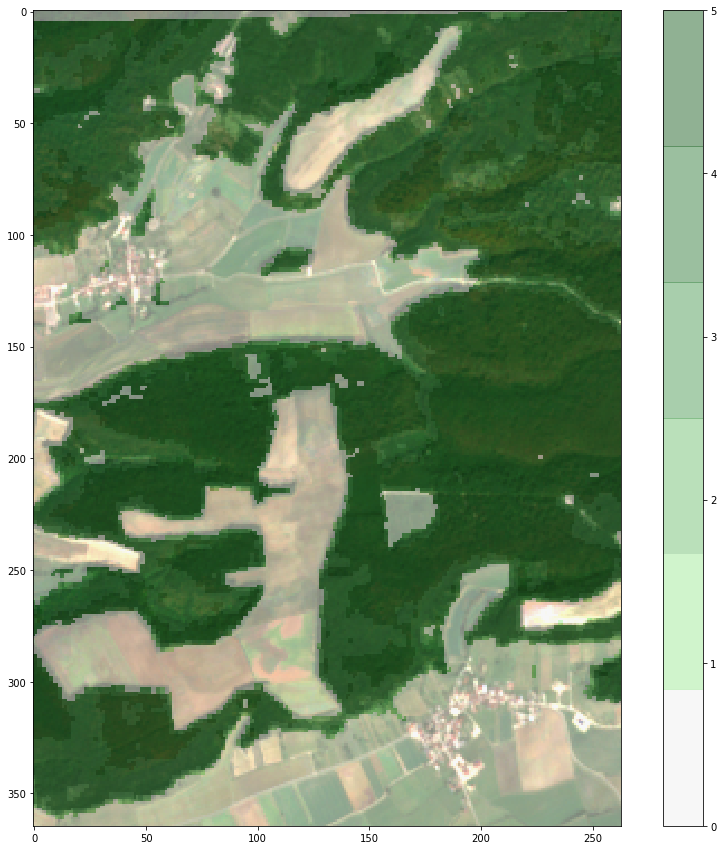

In [13]:
mp = example_patch.data_timeless['MEDIAN_PIXEL']
plt.figure(figsize=(15,15))
plt.imshow(2.5*mp)
tc = example_patch.mask_timeless['TREE_COVER']
plt.imshow(tc[...,0], vmin=0, vmax=5, alpha=.5, cmap=tree_cmap)
plt.colorbar()

## 2. Run workflow on all patches

In [14]:
# run over multiple bboxes
subset_idx = len(bbox_splitter.bbox_list)
x_train_raw = np.empty((subset_idx, img_height, img_width, 3))
y_train_raw = np.empty((subset_idx, img_height, img_width, 1))
pbar = tqdm(total=subset_idx)
for idx in range(0, subset_idx):
    patch = execute_workflow(idx)
    x_train_raw[idx] = patch.data_timeless['MEDIAN_PIXEL'][20:276,0:256,:]
    y_train_raw[idx] = patch.mask_timeless['TREE_COVER'][20:276,0:256,:]
    pbar.update(1)

## 3. Create training and validation data arrays

In [15]:
# data normalization and augmentation
img_mean = np.mean(x_train_raw, axis=(0, 1, 2))
img_std = np.std(x_train_raw, axis=(0, 1, 2))
x_train_mean = x_train_raw - img_mean
x_train = x_train_mean - img_std

train_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180)

y_train = to_categorical(y_train_raw, len(raster_value))

## 4. Set up U-net model using Keras (tensorflow back-end)

In [16]:
# Model setup
#from https://www.kaggle.com/lyakaap/weighing-boundary-pixels-loss-script-by-keras2
# weight: weighted tensor(same shape with mask image)
def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
            y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + \
    weighted_dice_loss(y_true, y_pred, weight)
    return loss

def unet(input_size):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(len(raster_value), 1, activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = weighted_bce_dice_loss, 
                  metrics = ['accuracy'])

    return model

model = unet(input_size=(256, 256, 3))

## 5. Train the model

In [18]:
# Fit the model
batch_size = 16
model.fit_generator(
        train_gen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train),
        epochs=20,
        verbose=1)
model.save(op.join('model.h5'))

Epoch 1/20
190/190 [==============================] - 419s 2s/step - loss: 0.9654 - acc: 0.6208
Epoch 2/20
190/190 [==============================] - 394s 2s/step - loss: 0.9242 - acc: 0.6460
Epoch 3/20
190/190 [==============================] - 394s 2s/step - loss: 0.9126 - acc: 0.6502
Epoch 4/20
190/190 [==============================] - 393s 2s/step - loss: 0.9059 - acc: 0.6540
Epoch 5/20
190/190 [==============================] - 393s 2s/step - loss: 0.9051 - acc: 0.6575
Epoch 6/20
190/190 [==============================] - 393s 2s/step - loss: 0.8940 - acc: 0.6620
Epoch 7/20
190/190 [==============================] - 394s 2s/step - loss: 0.8896 - acc: 0.6654
Epoch 8/20
190/190 [==============================] - 393s 2s/step - loss: 0.8870 - acc: 0.6668
Epoch 9/20
190/190 [==============================] - 393s 2s/step - loss: 0.8844 - acc: 0.6671
Epoch 10/20
190/190 [==============================] - 393s 2s/step - loss: 0.8781 - acc: 0.6708
Epoch 11/20
190/190 [==================

## 6. Validate model and show some results

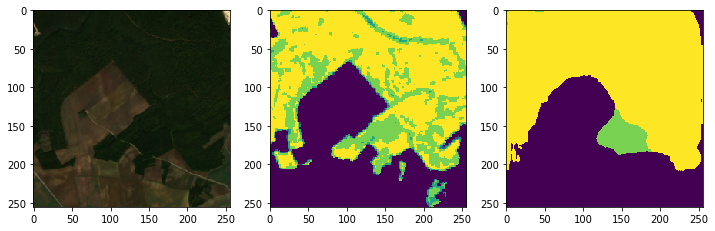

In [19]:
# plot one example (image, label, prediction)
idx = 4
p = np.argmax(model.predict(np.array([x_train[idx]])), axis=3)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(x_train_raw[idx])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(y_train_raw[idx][:,:,0])
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(p[0])

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.93412552 0.         0.         0.         0.01624412 0.04963036]
 [0.75458006 0.         0.         0.         0.08682321 0.15859672]
 [0.73890185 0.         0.         0.         0.1051384  0.15595975]
 [0.6504189  0.         0.         0.         0.1332155  0.2163656 ]
 [0.36706531 0.         0.         0.         0.18843914 0.44449555]
 [0.1816605  0.         0.         0.         0.05291638 0.76542312]]


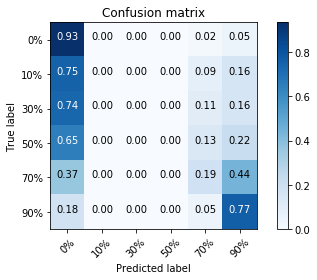

In [22]:
# show image confusion matrix
predictions = np.argmax(model.predict(x_train), axis=3)
cnf_matrix = confusion_matrix(y_train_raw.reshape(len(y_train_raw) * 256 * 256, 1), 
                              predictions.reshape(len(predictions) * 256 * 256, 1))
plot_confusion_matrix(cnf_matrix, raster_value.keys(), normalize=True)